In [1]:
using CARMA
using DataFrames
using Ensemble
using FITSIO
using HDF5
using Printf
using PyCall
using PyPlot
using Query
using Statistics

corner = pyimport("corner")
sns = pyimport("seaborn")

sns.set_context("notebook")
sns.set_style("ticks")
sns.set_palette("colorblind")

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/wfarr/.julia/packages/PyPlot/4wzW1/src/init.jl:192


In [2]:
visitdata = FITS("../apogee/allVisit-v603.fits")
stardata = FITS("../apogee/allStar-v603.fits")

try
    global visitframe = DataFrame()
    for cn in FITSIO.colnames(visitdata[2])
        visitframe[!, Symbol(cn)] = read(visitdata[2], cn)
    end
    
    global starframe = DataFrame()
    for cn in FITSIO.colnames(stardata[2])
        d = read(stardata[2], cn)
        if length(size(d)) == 1
            starframe[!, Symbol(cn)] = d
        end
    end    
finally
    close(visitdata)
    close(stardata)
end

In [3]:
jointframe = join(visitframe, starframe, on = :APOGEE_ID, makeunique=true)

,VISIT_ID,APRED_VERSION,APOGEE_ID,TARGET_ID
,String,String,String,String
1,apogee.apo1m.s.r5.calibration.56398.VESTA,r5,VESTA,1.calibration.VESTA
2,apogee.apo1m.s.r5.calibration.56778.VESTA,r5,VESTA,1.calibration.VESTA
3,apogee.apo25m.s.r5.5583.56257.5,r5,2M00000032+5737103,4424.2M00000032+5737103
4,apogee.apo25m.s.r5.5583.56257.5,r5,2M00000032+5737103,4424.2M00000032+5737103
5,apogee.apo25m.s.r5.5583.56261.17,r5,2M00000032+5737103,4424.2M00000032+5737103
6,apogee.apo25m.s.r5.5583.56261.17,r5,2M00000032+5737103,4424.2M00000032+5737103
7,apogee.apo25m.s.r5.5583.56284.56,r5,2M00000032+5737103,4424.2M00000032+5737103
8,apogee.apo25m.s.r5.5583.56284.56,r5,2M00000032+5737103,4424.2M00000032+5737103
9,apogee.apo25m.s.r5.5094.55874.268,r5,2M00000032+5737103,4264.2M00000032+5737103


In [4]:
rgframe = @from i in jointframe begin
          @where (i.LOGG < 1.5) && (i.LOGG > 0) 
          @select i
          @collect DataFrame
end

,VISIT_ID,APRED_VERSION,APOGEE_ID,TARGET_ID
,String,String,String,String
1,apogee.apo25m.s.r5.5583.56257.58,r5,2M00000317+5821383,4424.2M00000317+5821383
2,apogee.apo25m.s.r5.5583.56261.57,r5,2M00000317+5821383,4424.2M00000317+5821383
3,apogee.apo25m.s.r5.5583.56284.52,r5,2M00000317+5821383,4424.2M00000317+5821383
4,apogee.apo25m.s.r5.7061.56590.147,r5,2M00002227+6223341,4591.2M00002227+6223341
5,apogee.apo25m.s.r5.7061.56611.124,r5,2M00002227+6223341,4591.2M00002227+6223341
6,apogee.apo25m.s.r5.7061.56636.135,r5,2M00002227+6223341,4591.2M00002227+6223341
7,apogee.apo25m.s.r5.7061.56637.135,r5,2M00002227+6223341,4591.2M00002227+6223341
8,apogee.apo25m.s.r5.5218.55821.268,r5,2M00004072+5714404,4264.2M00004072+5714404
9,apogee.apo25m.s.r5.5218.55824.262,r5,2M00004072+5714404,4264.2M00004072+5714404


In [5]:
sort!(rgframe, [:APOGEE_ID, :JD])

,VISIT_ID,APRED_VERSION,APOGEE_ID,TARGET_ID
,String,String,String,String
1,apogee.apo25m.s.r5.5583.56257.58,r5,2M00000317+5821383,4424.2M00000317+5821383
2,apogee.apo25m.s.r5.5583.56261.57,r5,2M00000317+5821383,4424.2M00000317+5821383
3,apogee.apo25m.s.r5.5583.56284.52,r5,2M00000317+5821383,4424.2M00000317+5821383
4,apogee.apo25m.s.r5.7061.56590.147,r5,2M00002227+6223341,4591.2M00002227+6223341
5,apogee.apo25m.s.r5.7061.56611.124,r5,2M00002227+6223341,4591.2M00002227+6223341
6,apogee.apo25m.s.r5.7061.56636.135,r5,2M00002227+6223341,4591.2M00002227+6223341
7,apogee.apo25m.s.r5.7061.56637.135,r5,2M00002227+6223341,4591.2M00002227+6223341
8,apogee.apo25m.s.r5.5218.55821.268,r5,2M00004072+5714404,4264.2M00004072+5714404
9,apogee.apo25m.s.r5.5218.55824.262,r5,2M00004072+5714404,4264.2M00004072+5714404


In [6]:
rg_visits_lt5 = by(rgframe, :APOGEE_ID, num_lt5 = :JD => t -> sum(diff(t) .< 5))
sort!(rg_visits_lt5, :num_lt5, rev=true)

,APOGEE_ID,num_lt5
,String,Int64
1,2M21330683+1209406,25
2,2M19480168+2349089,22
3,2M18505142-0205119,21
4,2M18510234-0150075,21
5,2M21300637+1206592,17
6,2M16272112-1421262,14
7,2M18280585-0136290,13
8,2M18301891-0145486,13
9,2M18344204+0027277,13


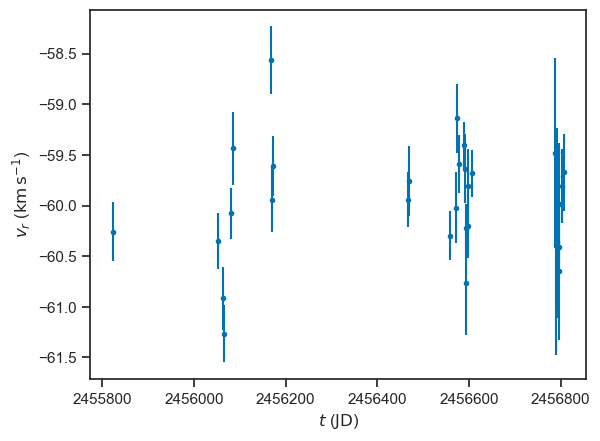

2M19480168+2349089 has LOG(g) = 1.4


PyObject Text(32.900000000000006, 0.5, '$v_r$ ($\\mathrm{km} \\, \\mathrm{s}^{-1}$)')

In [19]:
i = 2
id = rg_visits_lt5[i, :APOGEE_ID]
d = jointframe[jointframe.APOGEE_ID .== id, :]
sort!(d, :JD)
errorbar(d.JD, d.VHELIO, d.VRELERR, fmt=".")
println(@sprintf("%s has LOG(g) = %.1f", id, median(d.LOGG)))

xlabel(L"$t$ ($\mathrm{JD}$)")
ylabel(L"$v_r$ ($\mathrm{km} \, \mathrm{s}^{-1}$)")

In [20]:
nan_sel = isnan.(d.JD) .| isnan.(d.VHELIO) .| isnan.(d.VRELERR)
post = CARMA.Kalman.CARMAKalmanPosterior(d.JD[.!nan_sel], d.VHELIO[.!nan_sel], d.VRELERR[.!nan_sel], 3, 2)
ns = EnsembleNest.NestState(x -> CARMA.Kalman.log_likelihood(post, x), x -> CARMA.Kalman.log_prior(post, x), CARMA.Kalman.init(post, 1024), 128);

In [21]:
EnsembleNest.run!(ns, 0.01, verbose=false)
h5open("../CARMA-runs/$(id).h5", "w") do f
    post_group = g_create(f, "post")
    nest_group = g_create(f, "nest_state")
    
    write(post_group, post)
    write(nest_group, ns)
end

1.0

In [22]:
postsamples, logls = EnsembleNest.postsample(ns)
ps = [CARMA.Kalman.to_params(post, postsamples[:,i]) for i in 1:size(postsamples,2)];

In [23]:
fs = exp.(range(log(1/100.0), stop=log(10), length=1024))
psds = zeros(length(fs), length(ps))
for (i, p) in enumerate(ps)
    psds[:,i] = CARMA.Kalman.psd(post, p, fs)
end

In [24]:
m = zeros(length(fs))
h = zeros(length(fs))
l = zeros(length(fs))

for i in 1:length(fs)
    x = vec(psds[i,:])
    m[i] = median(x)
    h[i] = quantile(x, 0.84)
    l[i] = quantile(x, 0.16)
end

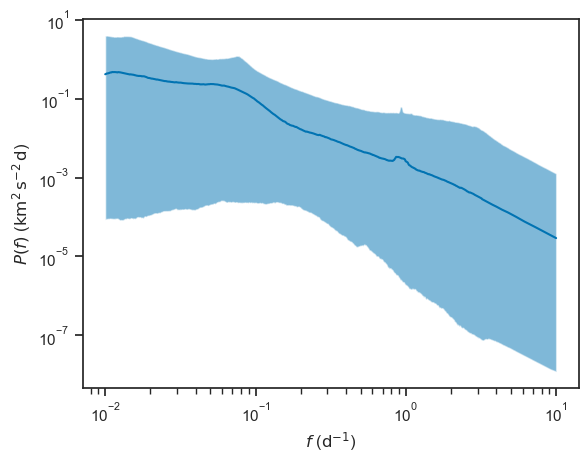

PyObject Text(32.900000000000006, 0.5, '$P(f)$ ($\\mathrm{km}^2 \\, \\mathrm{s}^{-2} \\, \\mathrm{d}$)')

In [25]:
loglog(fs, m)
fill_between(fs, h, l, alpha=0.5)

xlabel(L"$f$ ($\mathrm{d}^{-1}$)")
ylabel(L"$P(f)$ ($\mathrm{km}^2 \, \mathrm{s}^{-2} \, \mathrm{d}$)")

$\nu$ is the errorbar scaling factor: $\sigma = \nu \sigma_\mathrm{quoted}$

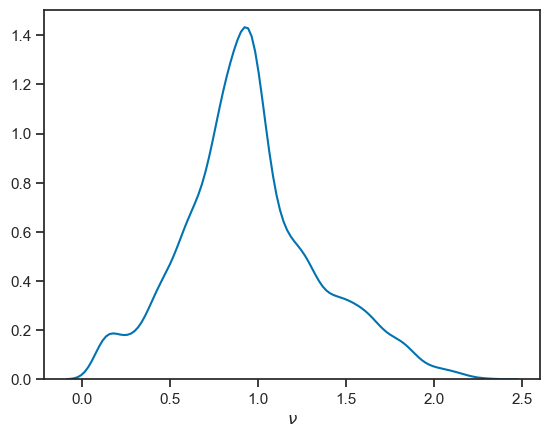

PyObject Text(0.5, 25.0, '$\\nu$')

In [26]:
sns.kdeplot([p.nu for p in ps])
xlabel(L"$\nu$")

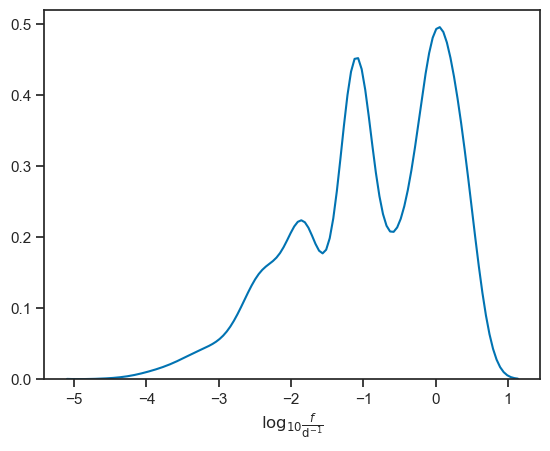

PyObject Text(0.5, 39.09833333333333, '$\\log_{10} \\frac{f}{\\mathrm{d}^{-1}}$')

In [27]:
sns.kdeplot([log10(CARMA.Kalman.frequencies(post, p)[2]) for p in ps])
xlabel(L"$\log_{10} \frac{f}{\mathrm{d}^{-1}}$")

In [28]:
resid = zeros(sum(.!nan_sel), length(ps))
sd_resid = zeros(sum(.!nan_sel), length(ps))
for (i, p) in enumerate(ps)
    r, s = CARMA.Kalman.residuals(post, p)
    resid[:,i] = r
    sd_resid[:,i] = s
end

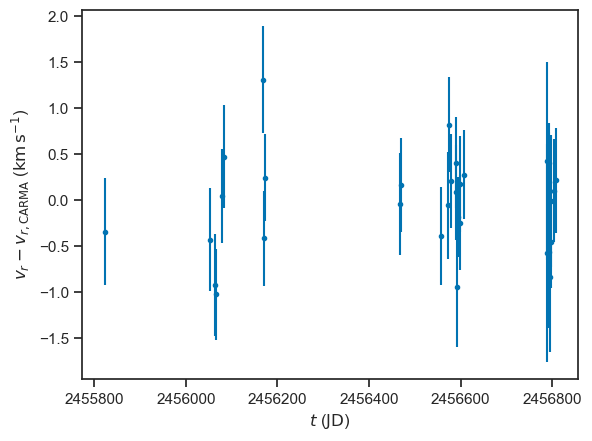

PyObject Text(33.2, 0.5, '$v_r - v_{r,\\mathrm{CARMA}}$ ($\\mathrm{km} \\, \\mathrm{s}^{-1}$)')

In [29]:
errorbar(d.JD[.!nan_sel], vec(mean(resid, dims=2)), vec(sqrt.(mean(sd_resid.*sd_resid, dims=2))), fmt=".")
xlabel(L"$t$ ($\mathrm{JD}$)")
ylabel(L"$v_r - v_{r,\mathrm{CARMA}}$ ($\mathrm{km} \, \mathrm{s}^{-1}$)")

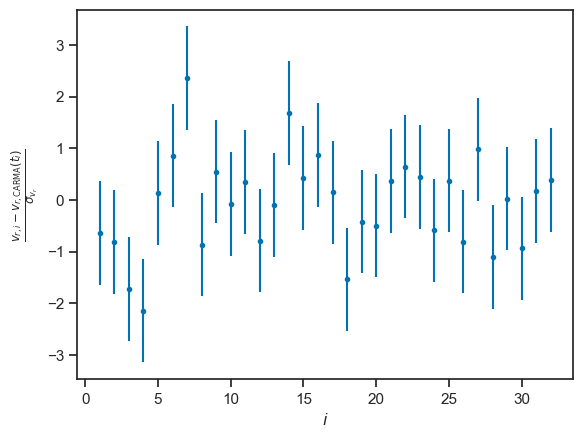

PyObject Text(41.19133333333335, 0.5, '$\\frac{v_{r,i} - v_{r,\\mathrm{CARMA}} \\left( t_i \\right)}{\\sigma_{v_r}}}$')

In [30]:
errorbar(range(1, stop=size(resid,1)), vec(mean(resid ./ sd_resid, dims=2)), ones(size(resid,1)), fmt=".")
xlabel(L"$i$")
ylabel(L"$\frac{v_{r,i} - v_{r,\mathrm{CARMA}} \left( t_i \right)}{\sigma_{v_r}}}$")